# Flight Delay Analysis - Logistic Regression Model Training

## Phase 5: Building and Evaluating Logistic Regression Models

In [1]:
import sys
# Remove any existing references to your module
if 'src.models.logistic_regression' in sys.modules:
    del sys.modules['src.models.logistic_regression']
    print("✓ Cleared old module reference.")

if 'src.models' in sys.modules:
    del sys.modules['src.models']
    print("✓ Cleared old package reference.")

In [2]:
# 1. Setup and Imports
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc
from IPython.display import display
# In your setup cell (Cell 2 or earlier)
from sklearn.preprocessing import StandardScaler

# Import Logistic Regression model functions
from src.models.logistic_regression import (
    load_engineered_data,
    prepare_data_for_modeling,
    train_logistic_regression,
    evaluate_classifier,
    get_feature_coefficients,
    save_model,
    tune_logistic_regression_hyperparams
)

# Set up paths
input_path = Path('../data/processed/flight_delays_engineered.csv') # Assuming this is the output of 03_feature_engineering
results_dir = Path('../results')
figures_dir = Path('../results/figures')

results_dir.mkdir(parents=True, exist_ok=True)
figures_dir.mkdir(parents=True, exist_ok=True)

print("✓ Imports and path setup complete.")

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

✓ Imports and path setup complete.


In [3]:
# Reload external files
%load_ext autoreload
%autoreload 2

---
## Part 1: Load Engineered Data
---

In [4]:
# 2. Data Loading
df = load_engineered_data(input_path)
print(f"✓ Loaded {len(df):,} rows and {len(df.columns)} columns.")

print(f"\nDataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()


✓ Loaded 1,527,160 rows and 19 columns.

Dataset shape: (1527160, 19)

First few rows:


,Date (YYYY-MM-DD),Scheduled Elapsed Time (Minutes),IsWeekend,Is_Holiday_Period,Carrier_9E,Carrier_AA,Carrier_AS,Carrier_DL,Carrier_EV,Carrier_MQ,Carrier_NK,Carrier_OO,Carrier_UA,Carrier_WN,Carrier_YX,Origin_Airport_Encoded,Season_Encoded,Arrival Delay (Minutes),Is_Delayed
0,2019-01-01,83,0,1,1,0,0,0,0,0,0,0,0,0,0,67,3,-1,0
1,2019-01-01,72,0,1,1,0,0,0,0,0,0,0,0,0,0,163,3,-14,0
2,2019-01-01,85,0,1,1,0,0,0,0,0,0,0,0,0,0,86,3,9,0
3,2019-01-01,112,0,1,1,0,0,0,0,0,0,0,0,0,0,16,3,-7,0
4,2019-01-01,129,0,1,1,0,0,0,0,0,0,0,0,0,0,28,3,-32,0


In [5]:
# 3. Define Features and Targets
# The feature set should be the same as used for Random Forest
exclude_cols = ['Date (YYYY-MM-DD)', 'Carrier Code', 'Origin Airport', 
                'Season', 'Arrival Delay (Minutes)', 'Is_Delayed']

feature_cols = [col for col in df.columns if col not in exclude_cols]

target_classification = 'Is_Delayed' # Target for the classifier (0 or 1)

print(f"\nTotal features for modeling: {len(feature_cols)}")
print(f"\nFeature list:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2}. {col}")


Total features for modeling: 16

Feature list:
   1. Scheduled Elapsed Time (Minutes)
   2. IsWeekend
   3. Is_Holiday_Period
   4. Carrier_9E
   5. Carrier_AA
   6. Carrier_AS
   7. Carrier_DL
   8. Carrier_EV
   9. Carrier_MQ
  10. Carrier_NK
  11. Carrier_OO
  12. Carrier_UA
  13. Carrier_WN
  14. Carrier_YX
  15. Origin_Airport_Encoded
  16. Season_Encoded


---
## Part 2: Classification Task - Predicting Delay vs On-time
---

### 2.1 Prepare Data for Classification

In [6]:
# 4. Data Split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = prepare_data_for_modeling(
    df=df,
    feature_cols=feature_cols,
    target_col=target_classification,
    test_size=0.2,
    random_state=42
)

print(f"\nTarget distribution (training set):")
print(y_train_clf.value_counts())
print(f"\nClass balance:")
print(y_train_clf.value_counts(normalize=True))


STARTING DATA SPLIT
  Training set: 1,221,728 samples
  Test set: 305,432 samples
  Feature dimensions: 16

Target distribution (training set):
Is_Delayed
0    1035253
1     186475
Name: count, dtype: int64

Class balance:
Is_Delayed
0    0.847368
1    0.152632
Name: proportion, dtype: float64


In [7]:
# NEW CELL: Feature Scaling for Logistic Regression - I tried running rithout this cell but the 1st model ran for over 3min and 
# did not converge. Now it ocnverges in 20s - chck functionallity???

print("\n" + "=" * 80)
print("SCALING FEATURES FOR LOGISTIC REGRESSION")
print("=" * 80)

# 1. Initialize the scaler
scaler = StandardScaler()

# 2. Fit the scaler on the training features (X_train)
#    and transform both training and test features.
X_train_clf_scaled = scaler.fit_transform(X_train_clf)
X_test_clf_scaled = scaler.transform(X_test_clf)

# We convert back to DataFrame to keep column names, 
# although the scaler output is an array. We'll use the array for training.

print("✓ Features successfully scaled (StandardScaler applied).")
print(f"  Training features shape after scaling: {X_train_clf_scaled.shape}")


SCALING FEATURES FOR LOGISTIC REGRESSION
✓ Features successfully scaled (StandardScaler applied).
  Training features shape after scaling: (1221728, 16)


### 2.2a Train Logistic Regression Classifier (Standard)

In [8]:
# 5. Model Training (Standard)
print("\n" + "=" * 80)
print("TRAINING LOGISTIC REGRESSION (STANDARD)")
print("=" * 80)

lr_classifier = train_logistic_regression(
    X_train=X_train_clf_scaled,
    y_train=y_train_clf,
    C=0.01, # we tried decreasing lambda
    solver='saga',
    random_state=42,
    n_jobs=-1,
    verbose=1,       # Set to 1 to see the convergence status
    # --------------------------------
    max_iter=5000,   
)


TRAINING LOGISTIC REGRESSION (STANDARD)

STARTING LOGISTIC REGRESSION TRAINING


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1
Epoch 2, change: 0.16734027
Epoch 3, change: 0.1132498
Epoch 4, change: 0.065681816
Epoch 5, change: 0.059006788
Epoch 6, change: 0.034745377
Epoch 7, change: 0.013436738
Epoch 8, change: 0.016227519
Epoch 9, change: 0.0031588752
Epoch 10, change: 0.0014126678
Epoch 11, change: 0.0018026355
Epoch 12, change: 0.0012681265
Epoch 13, change: 0.00053321072
Epoch 14, change: 0.00089663467
convergence after 15 epochs took 8 seconds
✓ Model trained in: 8.04 seconds


### 2.2b Train Logistic Regression (with class_weight)

In [9]:
# 6. Model Training (Balanced)
# We often compare the standard model to a model that handles imbalance.
print("\n" + "=" * 80)
print("TRAINING LOGISTIC REGRESSION (BALANCED CLASS WEIGHTS)")
print("=" * 80)

lr_classifier_balanced = train_logistic_regression(
    X_train=X_train_clf_scaled, #X_train_clf,
    y_train=y_train_clf,
    C=0.01,
    solver='saga',
    class_weight='balanced', # CRITICAL for handling imbalance
    random_state=42,
    n_jobs=-1,
    verbose=1,
    max_iter=10000 # Increased limit for the complex, weighted optimization
)


TRAINING LOGISTIC REGRESSION (BALANCED CLASS WEIGHTS)

STARTING LOGISTIC REGRESSION TRAINING


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1
Epoch 2, change: 0.2348856
Epoch 3, change: 0.16377509
Epoch 4, change: 0.079359092
Epoch 5, change: 0.095780673
Epoch 6, change: 0.072689958
Epoch 7, change: 0.05086562
Epoch 8, change: 0.021378936
Epoch 9, change: 0.018061025
Epoch 10, change: 0.0090308449
Epoch 11, change: 0.0054373736
Epoch 12, change: 0.028579192
Epoch 13, change: 0.016959539
Epoch 14, change: 0.053917136
Epoch 15, change: 0.053147795
Epoch 16, change: 0.0042280761
Epoch 17, change: 0.043241195
Epoch 18, change: 0.053466938
Epoch 19, change: 0.0026262265
Epoch 20, change: 0.0039520162
Epoch 21, change: 0.0027380339
Epoch 22, change: 0.0042884216
Epoch 23, change: 0.0042993521
Epoch 24, change: 0.0035127052
Epoch 25, change: 0.0060459643
Epoch 26, change: 0.011240067
Epoch 27, change: 0.0093525036
Epoch 28, change: 0.0017086712
Epoch 29, change: 0.0054365001
Epoch 30, change: 0.0030179472
Epoch 31, change: 0.0027953521
Epoch 32, change: 0.0043108192
Epoch 33, change: 0.00053330526
Epoch 34, chang

In [85]:
# NOTE: YET TODO!! # HAVE NOT RUN THIS CELL YET BC IT MIGHT TAKE LIKE 30MINS - this was here bc currently the scores are very 
# bad and theoretically this would tell su which hyperparams to use for the best score
"""best_model, best_params = tune_logistic_regression_hyperparams( 
    X_train=X_train_clf_scaled,
    y_train=y_train_clf,
    cv=5
)
clf_metrics_tuned = evaluate_classifier(
    model=best_model,
    X_test=X_test_clf_scaled,
    y_test=y_test_clf
)"""

'best_model, best_params = tune_logistic_regression_hyperparams( \n    X_train=X_train_clf_scaled,\n    y_train=y_train_clf,\n    cv=5\n)\nclf_metrics_tuned = evaluate_classifier(\n    model=best_model,\n    X_test=X_test_clf_scaled,\n    y_test=y_test_clf\n)'

### 2.3 Evaluate Classifier Performance

In [11]:
# 7. Model Evaluation (Balanced Model)
# We primarily evaluate the balanced model as it is more robust to imbalance.

clf_metrics = evaluate_classifier(
    model=lr_classifier,
    X_train=X_train_clf_scaled,
    y_train=y_train_clf,
    X_test=X_test_clf_scaled,
    y_test=y_test_clf
)
# observe that TP=0 in the non balanced case, that is the whole reason why weuse balancing
clf_metrics_balanced = evaluate_classifier(
    model=lr_classifier_balanced,
    X_train=X_train_clf_scaled,
    y_train=y_train_clf,
    X_test=X_test_clf_scaled,
    y_test=y_test_clf
)


CLASSIFIER EVALUATION (LogisticRegression)

Training Set Performance:
  Accuracy  : 0.8474
  Precision : 0.0000
  Recall    : 0.0000
  F1        : 0.0000

Test Set Performance:
  Accuracy  : 0.8481
  Precision : 0.0000
  Recall    : 0.0000
  F1        : 0.0000
  Roc_auc   : 0.5805

Confusion Matrix (Test Set):
[[259046      0]
 [ 46386      0]]

Classification Report (Test Set):
              precision    recall  f1-score   support

     Class 0       0.85      1.00      0.92    259046
     Class 1       0.00      0.00      0.00     46386

    accuracy                           0.85    305432
   macro avg       0.42      0.50      0.46    305432
weighted avg       0.72      0.85      0.78    305432


CLASSIFIER EVALUATION (LogisticRegression)

Training Set Performance:
  Accuracy  : 0.6021
  Precision : 0.1884
  Recall    : 0.4856
  F1        : 0.2714

Test Set Performance:
  Accuracy  : 0.6000
  Precision : 0.1858
  Recall    : 0.4832
  F1        : 0.2684
  Roc_auc   : 0.5805

Confus

In [13]:
print("MODEL COMPARISON: Original vs Balanced")
print("=" * 60)

comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Original Model': [
        f"{clf_metrics['test_metrics']['accuracy']:.4f}",
        f"{clf_metrics['test_metrics']['precision']:.4f}",
        f"{clf_metrics['test_metrics']['recall']:.4f}",
        f"{clf_metrics['test_metrics']['f1']:.4f}",
        f"{clf_metrics['test_metrics']['roc_auc']:.4f}"
    ],
    'Balanced Model': [
        f"{clf_metrics_balanced['test_metrics']['accuracy']:.4f}",
        f"{clf_metrics_balanced['test_metrics']['precision']:.4f}",
        f"{clf_metrics_balanced['test_metrics']['recall']:.4f}",
        f"{clf_metrics_balanced['test_metrics']['f1']:.4f}",
        f"{clf_metrics_balanced['test_metrics']['roc_auc']:.4f}"
    ]
})

print("\n")
print(comparison_df.to_string(index=False))


MODEL COMPARISON: Original vs Balanced


   Metric Original Model Balanced Model
 Accuracy         0.8481         0.6000
Precision         0.0000         0.1858
   Recall         0.0000         0.4832
 F1-Score         0.0000         0.2684
  ROC-AUC         0.5805         0.5805


### 2.4 Feature Importance (Classification)

In [14]:
# 8. Feature Coefficients
# Unlike feature importance in RF, LR uses coefficients to show feature influence.

coef_df = get_feature_coefficients(
    model=lr_classifier_balanced,
    feature_names=feature_cols,
    top_n=15
)


TOP 15 MOST INFLUENTIAL FEATURES (by Absolute Coefficient)
                         Feature  Coefficient  Abs(Coefficient)
                  Season_Encoded       0.1466            0.1466
                      Carrier_DL      -0.1083            0.1083
                      Carrier_NK       0.0897            0.0897
                      Carrier_AA       0.0893            0.0893
Scheduled Elapsed Time (Minutes)       0.0887            0.0887
                       IsWeekend       0.0685            0.0685
                      Carrier_WN       0.0467            0.0467
                      Carrier_UA       0.0460            0.0460
          Origin_Airport_Encoded      -0.0454            0.0454
                      Carrier_OO       0.0405            0.0405
                      Carrier_9E      -0.0295            0.0295
               Is_Holiday_Period      -0.0220            0.0220
                      Carrier_AS       0.0129            0.0129
                      Carrier_MQ       0.005

### 2.5 Visualize Classification Results

✓ Saved visualization to: ../results/figures/lr_classification_results.png


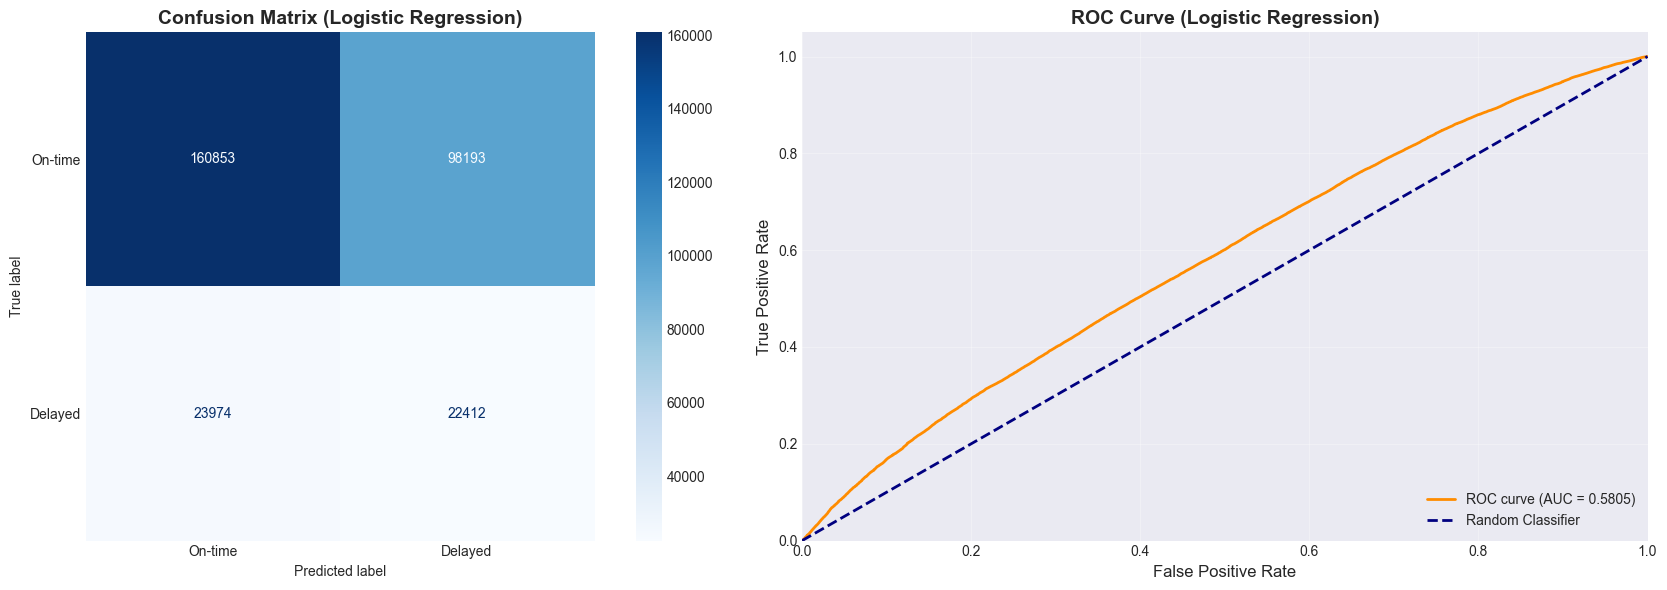

In [15]:
# 9. Visualization (Similar to 04_model_training_random_forest)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 1. Confusion Matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=clf_metrics_balanced['confusion_matrix'],
                                    display_labels=['On-time', 'Delayed'])
cm_display.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Confusion Matrix (Logistic Regression)', fontsize=14, fontweight='bold')
axes[0].grid(False)

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test_clf, clf_metrics_balanced['y_test_proba'])
roc_auc = auc(fpr, tpr)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('ROC Curve (Logistic Regression)', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(alpha=0.3)

plt.tight_layout()

# Save figure
plt.savefig(figures_dir / 'lr_classification_results.png', dpi=300, bbox_inches='tight')
print("✓ Saved visualization to: ../results/figures/lr_classification_results.png")
plt.show()

### 2.6 Save Classification Model

In [16]:
# Save the balanced model
save_model(lr_classifier_balanced, results_dir / 'logistic_regression_balanced_model.joblib')


✓ Model successfully saved to: ../results/logistic_regression_balanced_model.joblib


---
## Part 3: Model Comparison Summary
---

In [18]:
# 10. Results Summary

# Create and save a combined results summary (assuming the existing summary is loaded)
# This cell should be run AFTER the RF notebook to load and update the summary.

try:
    results_summary = pd.read_csv(results_dir / 'model_performance_summary.csv')

    # Safely extract metrics from nested dict
    test_metrics = clf_metrics_balanced.get('test_metrics', clf_metrics_balanced)

    # Add new LR results
    lr_results = pd.DataFrame({
        'Model': ['Logistic Regression Classifier (Balanced)'],
        'Task': ['Classification (Delay Detection)'],
        'Test_RMSE': [None],
        'Test_MAE': [None],
        'Test_R2': [None],
        'Test_Accuracy': [test_metrics.get('accuracy')],
        'Test_Precision': [test_metrics.get('precision')],
        'Test_Recall': [test_metrics.get('recall')],
        'Test_F1': [test_metrics.get('f1')],
        'Test_ROC_AUC': [test_metrics.get('roc_auc')]
    })

    results_summary = pd.concat([results_summary, lr_results], ignore_index=True)

except FileNotFoundError:
    # Handle case where RF summary file doesn't exist yet
    test_metrics = clf_metrics_balanced.get('test_metrics', clf_metrics_balanced)

    results_summary = pd.DataFrame({
        'Model': ['Logistic Regression Classifier (Balanced)'],
        'Task': ['Classification (Delay Detection)'],
        'Test_RMSE': [None],
        'Test_MAE': [None],
        'Test_R2': [None],
        'Test_Accuracy': [test_metrics.get('accuracy')],
        'Test_Precision': [test_metrics.get('precision')],
        'Test_Recall': [test_metrics.get('recall')],
        'Test_F1': [test_metrics.get('f1')],
        'Test_ROC_AUC': [test_metrics.get('roc_auc')]
    })

# Save combined summary
results_summary.to_csv(results_dir / 'model_performance_summary.csv', index=False)

print("\n✓ Results summary updated and saved to:", results_dir / 'model_performance_summary.csv')
print("\nCombined Results Summary:")
display(results_summary)

print("\n" + "=" * 80)
print("LOGISTIC REGRESSION TRAINING COMPLETE")
print("=" * 80)



✓ Results summary updated and saved to: ../results/model_performance_summary.csv

Combined Results Summary:


,Model,Task,Test_RMSE,Test_MAE,Test_R2,Test_Accuracy,Test_Precision,Test_Recall,Test_F1,Test_ROC_AUC
0,Logistic Regression Classifier (Balanced),Classification (Delay Detection),None,None,None,0.600019,0.18583,0.483163,0.268422,0.580467



LOGISTIC REGRESSION TRAINING COMPLETE
